# Nov 22, 2023: arHMM states on runwise timeseries

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
from os.path import join as pjoin
from itertools import product, combinations
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

from sklearn.decomposition import PCA
# networks
import networkx as nx
from sklearn.covariance import GraphicalLassoCV

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

In [3]:
args.parcel_name = 'whole'
BASE_path = f'/home/govindas/mouse_dataset/roi'
TS_path = f'{BASE_path}/roi_timeseries_txt_files/{args.parcel_name}'

In [4]:
args.num_subs = 10
args.num_sess = 3
args.num_rois = len(np.loadtxt(
        (
            f'/home/govindas/mouse_dataset/allen_atlas_ccfv3/hadi/parcellation'
            f'/warped_on_n162/{args.parcel_name}_roi_labels.txt'
        )
    ).astype(int)
)

main_sample = [
    [
        []
        for ses in range(args.num_sess)
    ]
    for sub in range(args.num_subs)
]
for file in os.listdir(TS_path):
    fs = file.split('_')
    if int(fs[2].split('-')[-1]) % 2 == 0: continue # skip even runs
    sub = int(fs[0].split('-')[-1][-2:])
    ses = int(fs[1].split('-')[-1])
    # run = int(fs[2].split('-')[-1])
    main_sample[sub-1][ses-1].append(file)

for sub in np.arange(1,args.num_subs+1):
    for ses in np.arange(1, args.num_sess+1):
        main_sample[sub-1][ses-1] = list(np.sort(main_sample[sub-1][ses-1]))

In [5]:
tss = []
ts_shapes = []
for sub, ses in tqdm(product(range(args.num_subs), range(args.num_sess))):
    for run in main_sample[sub][ses]:
        ts = np.loadtxt(f'{TS_path}/{run}')
        ts = stats.zscore(ts, axis=0, nan_policy='omit') # time x rois
        ts = np.nan_to_num(ts)
        tss.append(ts)
        ts_shapes.append(ts.shape)
ts = np.vstack(tss)
ts.shape

30it [00:06,  4.48it/s]


(56701, 1443)

In [6]:
args.num_comps = 200
try:
    with open(f'/home/govindas/network_estimation/results/temp_states/pca_tss_d{args.num_comps}.pkl', 'rb') as f:
        [ts_, tss_] = pickle.load(f)
except:
    pca = PCA(n_components=args.num_comps) 
    pca = pca.fit(ts)
    ts_ = pca.transform(ts)
    print(ts_.shape)

    tss_ = []
    ends = np.cumsum(np.vstack(ts_shapes)[:, 0])
    for idx_e, e in enumerate(ends):
        s = ends[idx_e-1] if idx_e > 0 else 0
        tss_.append(ts_[s:e, :])

    for i in range(len(tss)):
        assert tss[i].shape[0] == tss_[i].shape[0]
        
    with open(f'/home/govindas/network_estimation/results/temp_states/pca_tss_d{args.num_comps}.pkl', 'wb') as f:
        pickle.dump([ts_, tss_], f)

(56701, 200)


  0%|          | 0/200 [00:00<?, ?it/s]

K = 200


  0%|          | 0/200 [00:00<?, ?it/s]

K = 200


  0%|          | 0/200 [00:00<?, ?it/s]

K = 200


  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

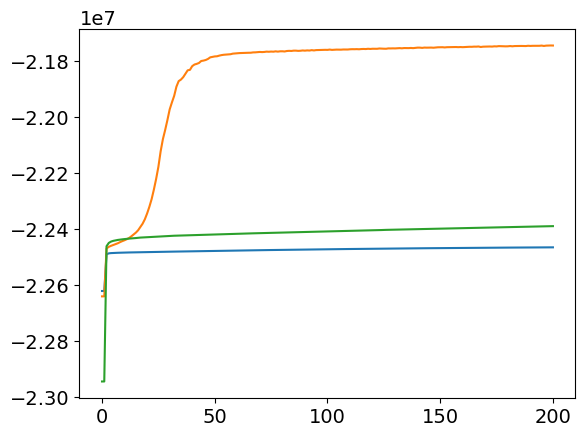

In [7]:
args.N_iters = 200
for args.num_states in range(2, 11):
    try:
        with open(
            (
                f'/home/govindas/network_estimation/results/temp_states'
                f'/arhmm_d{args.num_comps}_k{args.num_states}_i{args.N_iters}.pkl'
            ), 
            'rb'
        ) as f:
            arhmm = pickle.load(f)
    except:
        arhmm = ssm.HMM(
            K=args.num_states,
            D=args.num_comps,
            transitions='recurrent',
            observations='robust_autoregressive',
        )
        lls = arhmm.fit(
            tss_, 
            method='em', 
            num_iters=args.N_iters, 
            init_method='kmeans',
        )
        print(f'D = {args.num_comps}, K = {args.num_states}')
        with open(
            (
                f'/home/govindas/network_estimation/results/temp_states'
                f'/arhmm_d{args.num_comps}_k{args.num_states}_i{args.N_iters}.pkl'
            ), 
            'wb'
        ) as f:
            pickle.dump(arhmm, f)
        plt.plot(lls)

---

In [ ]:
args.num_states = 10
with open(
    (
        f'/home/govindas/network_estimation/results/temp_states'
        f'/arhmm_d{args.num_comps}_k{args.num_states}_i{args.N_iters}.pkl'
    ), 
    'rb'
) as f:
    arhmm = pickle.load(f)

In [ ]:
state_seqs = []
for ts_run in tss_:
    state_seqs.append(arhmm.most_likely_states(ts_run))

In [ ]:
state_seq = np.concatenate(state_seqs)
ts = np.vstack(tss)

state_ts = {}
state_fc = {}
vmin, vmax = [], []
for idx_state in range(args.num_states):
    state_ts[idx_state] = ts[state_seq == idx_state, :]
    fc = np.corrcoef(state_ts[idx_state], rowvar=False)
    fc -= np.diag(np.diag(fc))
    state_fc[idx_state] = fc
    vmin.append(np.min(fc))
    vmax.append(np.max(fc))

vmin = np.min(vmin)
vmax = np.max(vmax)

<AxesSubplot:>

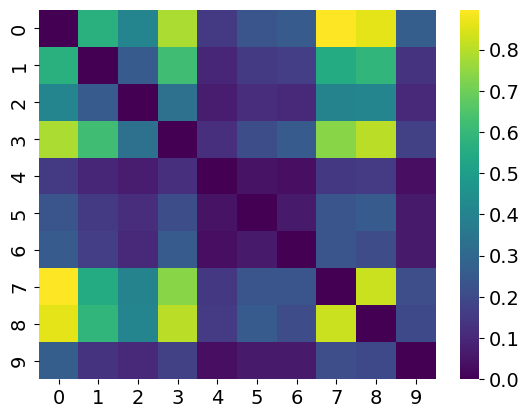

In [ ]:
fc_similarity = np.zeros((args.num_states, args.num_states))
for i, j in combinations(range(args.num_states), 2):
    fc_similarity[i, j] = np.corrcoef(
        x=state_fc[i][np.tril_indices(args.num_rois, k=-1)], 
        y=state_fc[j][np.tril_indices(args.num_rois, k=-1)]
    )[0, 1]

fc_similarity = (fc_similarity + fc_similarity.T) 
sns.heatmap(fc_similarity, cmap='viridis')

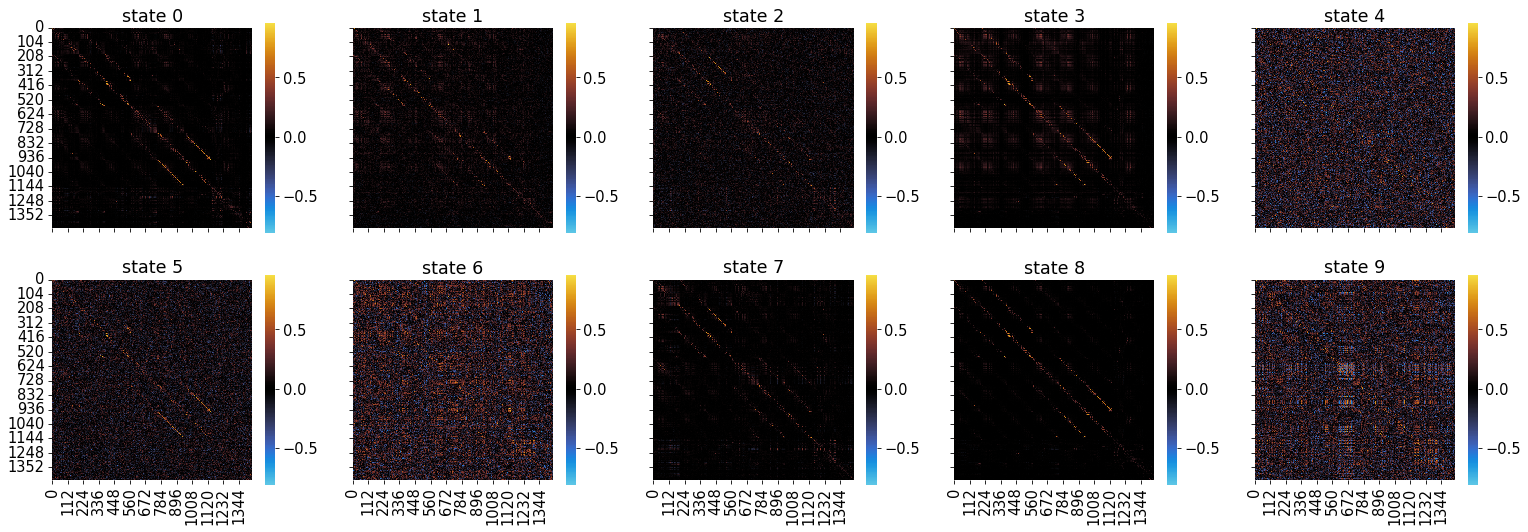

In [ ]:
nrows, ncols = 2, 5
fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), dpi=75,
    sharex=True, sharey=True
)

for r in range(nrows):
    for c in range(ncols):
        idx_state = ncols * r + c
        ax = axs[r, c]
        sns.heatmap(
            state_fc[idx_state], 
            square=True, 
            ax=ax, 
            cmap=cmr.iceburn,
            center=0,
            vmin=vmin, 
            vmax=vmax,
        )
        ax.set(title=f'state {idx_state}')